In [7]:
import numpy as np
import csv
import igl
import math
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import os
import plotly.graph_objects as go
from scipy.io import loadmat 
from scipy.stats import t

In [8]:
def readmitodata(fname):
    """
    Expect a filename of the form "mito_data???.mat" 
    where ??? is the mito number (left padded by 0 is necessary).
    
    argument:
    fname -- string, filename of the mito data
    
    returns:
    mito_dict -- dictionary, keys are the names of the variables in the matlab file
    The keys are:
    'mito' -- the mitochondrion binary shaoe (np.ndarray, has been padded with zeros)
    'vertices' -- the vertices of the meshed mitochondrion (np.ndarray)  
    'faces' -- the faces of the meshed mitochondrion (np.ndarray)
    'cristae_junctions' -- the vertices of the cristae junctions (np.ndarray) or empty list if none
    'min_coords' -- the minimum coordinates of the mitochondrion (np.ndarray) in the original volume    
    'mito_number' -- the number of the mitochondrion (int) from the cc3d.component_labeling function,
                        this is the same as the number in the filename
    
    """
    mito_dict = loadmat(fname)
    # remove matlab meta data
    del mito_dict['__header__']
    del mito_dict['__version__']
    del mito_dict['__globals__']
    mito_dict['mito_number'] = int(mito_dict['mito_number'])
    # inverted results in matlab....
    mito_dict['vertices'], mito_dict['faces'] = mito_dict['faces'], mito_dict['vertices']
    # count starts at 0
    mito_dict['faces'] -= 1
    return mito_dict

In [43]:
# Calculating the surface area of the mesh
def mesh_area(vecs, faces):
    double_areas = igl.doublearea(vecs, faces)
    surface_area = np.sum(double_areas) / 2.0
    return surface_area

# Ripley's K function for mesh
def ripleyK_mesh(area, dists, radii):
    K = np.zeros_like(radii)
    intensity = len(dists) / area
    for i in range(len(radii)):
        K[i] = np.sum(dists < radii[i])
    K = K/intensity
    return K, intensity

In [39]:
current_dir = os.getcwd()
mito_path = os.path.join(current_dir, "mito_data")

area_list = []
for file_name in os.listdir(mito_path):
    if file_name.endswith(".mat"):
        file_path = os.path.join(mito_path, file_name)
        mito = readmitodata(file_path)
        vertices = np.array(mito['vertices'], dtype=np.float64)
        faces = np.array(mito['faces'], dtype=np.int32)
        mito_number = mito['mito_number']
        area = mesh_area(vertices, faces)
        # print("Mito number: ", mito_number, "Area: ", area)
        data = (mito_number, area)
        area_list.append(data)      

np.savetxt("mito_area.csv", area_list, delimiter=",", header='Mito_number, Area of Mitochondria')

In [11]:
# file_path = os.path.join(current_dir, "mito_area.csv")
# with open(file_path, 'r') as file:
#     csvreader = csv.reader(file)
#     area_list = []
#     for row in csvreader:
#         area_list.append(row)
#     area_list = np.array(area_list[1:])

In [6]:
data_dir = os.path.join(current_dir, "mito_dists")

for file_name in os.listdir(data_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_dir, file_name)
        mito_number = os.path.splitext(file_name)[0][-3:] # get the mito number
        for a in area_list:
            if a[0] == int(mito_number):
                area = a[1]
        print("Mito number: ", mito_number, "Area: ", area)

Mito number:  002 Area:  4493.568077113537
Mito number:  007 Area:  19786.45576365618
Mito number:  008 Area:  22723.880554806943
Mito number:  013 Area:  57545.96308088785
Mito number:  014 Area:  17846.507122169056
Mito number:  015 Area:  10987.856343730917
Mito number:  016 Area:  32186.87854613799
Mito number:  024 Area:  46194.93044819569
Mito number:  027 Area:  7993.615007703276
Mito number:  028 Area:  200301.04784118262
Mito number:  029 Area:  215994.778591215
Mito number:  030 Area:  11715.824288822154
Mito number:  031 Area:  20445.943086876603
Mito number:  032 Area:  75651.69826490553
Mito number:  033 Area:  112603.08715069084
Mito number:  034 Area:  23775.703195032733
Mito number:  035 Area:  16509.045613209644
Mito number:  038 Area:  18969.17411743062
Mito number:  039 Area:  38592.63493719442
Mito number:  042 Area:  198915.35827878688
Mito number:  043 Area:  28551.969219879385
Mito number:  044 Area:  121456.58904318718
Mito number:  049 Area:  242651.4215891861


In [44]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "mito_dists")
result_dir = os.path.join(current_dir, "mito_result")

In [8]:
# file_path = os.path.join(data_dir, "mito_data007.csv")
# with open(file_path, 'r') as file:
#     csvreader = csv.reader(file)
#     dists = []
#     for row in csvreader:
#         dists.append(row)
#     dists = np.array(dists[1:], dtype=np.float64)
#     print(dists.shape)
#     rmax = np.max(dists)
#     radii = np.linspace(0, rmax+rmax/10, 50)
#     kt_mito = ripleyK_mesh(area, dists, radii)
#     data = np.column_stack((radii, kt_mito))
#     print(data)

In [45]:
intensities = []

for file_name in os.listdir(data_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_dir, file_name)
        with open(file_path, 'r') as file:
            mito_number = os.path.splitext(file_name)[0][-3:] # get the mito number
            for a in area_list:
                if a[0] == int(mito_number):
                    area = a[1]
            # print("Mito number: ", mito_number, "Area: ", area)
            csvreader = csv.reader(file)
            dists = []
            for row in csvreader:
                dists.append(row)
            dists = np.array(dists[1:], dtype=np.float64)
            rmax = np.max(dists)
            radii = np.linspace(0, rmax+rmax/10, 50)
            kt_mito, intensity = ripleyK_mesh(area, dists, radii)
            intensities.append(intensity)
            data = np.column_stack((radii, kt_mito))
            result_path = os.path.join(result_dir, "mito_result" + mito_number + ".csv")
            np.savetxt(result_path, data, delimiter=",", header='Radii, Kt')

In [46]:
combined_data = []

for file_name in os.listdir(result_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(result_dir, file_name)
        with open(file_path, 'r') as file:
            mito_number = os.path.splitext(file_name)[0][-3:] # get the mito number
            csvreader = csv.reader(file)
            data = []
            for row in csvreader:
                data.append(row)
            data = np.array(data[1:], dtype=np.float64)  # Convert data to float
            radii = data[:, 0]
            kt_mito = data[:, 1]

            # normalize radii to pi
            radii_normalized = np.pi * (radii - np.min(radii)) / (np.max(radii) - np.min(radii))
            # print(mito_number, radii_normalized)

            if len (combined_data) == 0:
                combined_data.append(radii_normalized)
            combined_data.append(kt_mito)

combined_data = np.array(combined_data)
print(combined_data.shape)

(280, 50)


In [47]:
kt_all = combined_data[1:]

radii_normalized = combined_data[0]
kt_mean = np.mean(kt_all, axis=0)

In [49]:
alpha = 0.05

se = np.std(kt_all, axis=0) / np.sqrt(len(kt_all))

df = len(kt_all) - 1
critical_value = t.ppf(1 - alpha / 2, df)

lower_bound = kt_mean - critical_value * se
upper_bound = kt_mean + critical_value * se

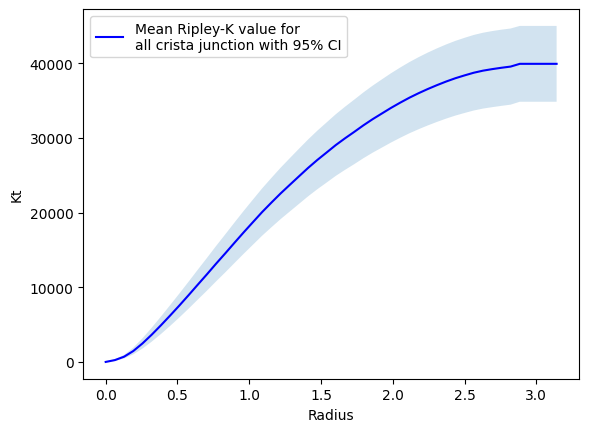

In [60]:
plt.plot(radii_normalized, kt_mean, color='blue', label='Mean Ripley-K value for \nall crista junction with 95% CI')
plt.fill_between(radii_normalized, lower_bound, upper_bound, alpha=0.2)
plt.xlabel("Radius")
plt.ylabel("Kt")
plt.legend(loc='upper left')
plt.savefig("kt_mito_mean.png")
plt.show()